# Training tree-based models for time series forecasting

After working with the ARIMA model yesterday, today you will use the same data to fit a Random Forest (RF) and XGBoost model on it.

Throughout the seminar, we will use the following splits for training, validation, and testing. Make sure to keep the tests unseen until the final evaluation (information leakage):

- Training set: 2009-2013
- Validation set: 2014
- Test set: 2015-2016

Required python packages: pandas, numpy, matplotlib, scikit-learn, xgboost

## Task 1: Feature Engineering

For random forest and xgboost, engineer features for the flu-trends dataset by incorporating lagged values (e.g., 8 weeks); ensure that your feature engineering process does not introduce information from future data points into past records.

> For instance, use the past 8 weeks to predict the next week.X-columns: FluVisits_t-8, FluVisits_t-7, ..., FluVisits_t-1
>
> You can also predict more than one week ahead. Then you need to shift the next samples accordingly.X-columns: FluVisits_t-8, FluVisits_t-7, ..., FluVisits_t-1
Y-columns: FluVisits_t, FluVisits_t+1, FluVisits_t+2

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import xgboost as xgb


In [2]:
test = pd.read_csv(os.path.join('..', 'data', 'interim', 'test.csv'))
train = pd.read_csv(os.path.join('..', 'data', 'interim', 'training.csv'))
val = pd.read_csv(os.path.join('..', 'data', 'interim', 'validation.csv'))

In [3]:
print(test.shape)
print(train.shape)
print(val.shape)

(78, 132)
(236, 132)
(52, 132)


```python
 def create_features(data: pd.DataFrame, target_column: str, feature_length: int = 8, prediction_length: int = 2) -> [np.ndarray, np.ndarray]:
    ...
    return X, y
```

In [4]:
def create_features(data: pd.DataFrame, target_column: str, feature_length: int = 8, prediction_length: int = 2) -> tuple[np.ndarray, np.ndarray]:
    """
    Create features and target arrays for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing the time series.
        target_column (str): The name of the target column to predict.
        feature_length (int, optional): The number of past observations to use as features. Defaults to 8.
        prediction_length (int, optional): The number of future observations to predict. Defaults to 2.

    Returns:
        tuple[np.ndarray, np.ndarray]: The feature and target arrays.
    """
    
    target_data = data[target_column].values
    for i in range(feature_length, len(data) - prediction_length + 1): # Iterate over rows from e.g. 8 to len(data)-2
        features = target_data[i-feature_length:i] # Get the last 8 values as features as np array
        target = target_data[i:i+prediction_length] # Get the next 2 values as target as np array
        # for first iteration, initialize X and y
        if i == feature_length:
            X = np.array([features])
            y = np.array(target)
        else: # Add new rows to ndarrays
            X = np.vstack([X, features])
            y = np.vstack([y, target])
    return X, y

In [5]:
X_train, y_train = create_features(train, target_column="FluVisits", prediction_length=2, feature_length=8)
X_train.shape, y_train.shape

((227, 8), (227, 2))

## Task 2: Fitting the models

Task 2.1: Fit a Random Forest model to the data. Evaluate the model using the test set.

In [6]:
#training
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)

X_test, y_test = create_features(test, target_column="FluVisits", prediction_length=2, feature_length=8)
y_predictions = rf.predict(X_test)
print(y_predictions.shape)

(69, 2)


In [7]:
#evaluation:
score = rf.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, y_predictions)
print(f"MSE: {mse}, MAPE: {mape}", f"R^2: {score}")

MSE: 41498.65905579709, MAPE: 0.22698652534581096 R^2: 0.6719457908495874


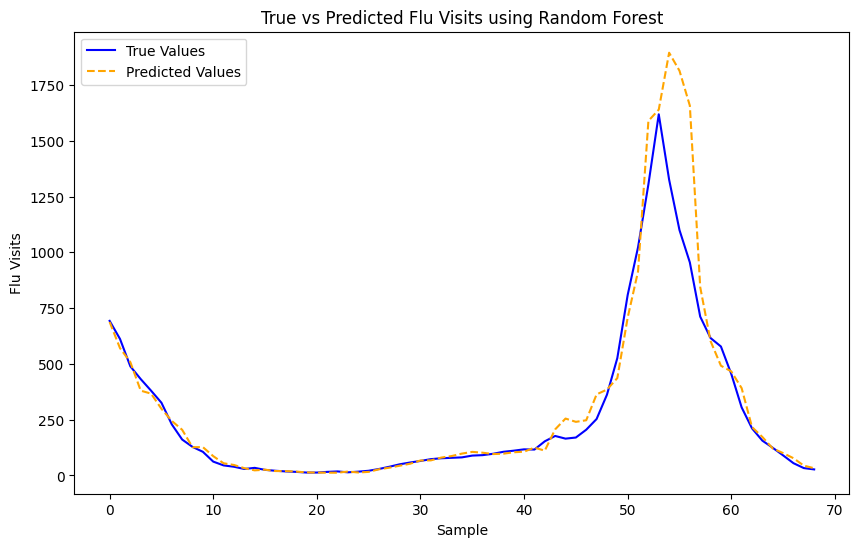

In [8]:
# visualization

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values', color='blue')
plt.plot(y_predictions[:, 0], label='Predicted Values', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Flu Visits')
plt.title('True vs Predicted Flu Visits using Random Forest')
plt.show()

Task 2.2: Fit a XGBoost model to the data. Evaluate the model using the test set.

In [9]:
xgb_reg = xgb.XGBRegressor(randompip_state=42)
xgb_reg.fit(X_train, y_train)
xgb_prediction = xgb_reg.predict(X_test)

c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "randompip_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
#evaluation:
mse = metrics.mean_squared_error(y_test, xgb_prediction)
mape = metrics.mean_absolute_percentage_error(y_test, xgb_prediction)
print(f"MSE: {mse}, MAPE: {mape}")


MSE: 50538.58203125, MAPE: 0.25446754693984985


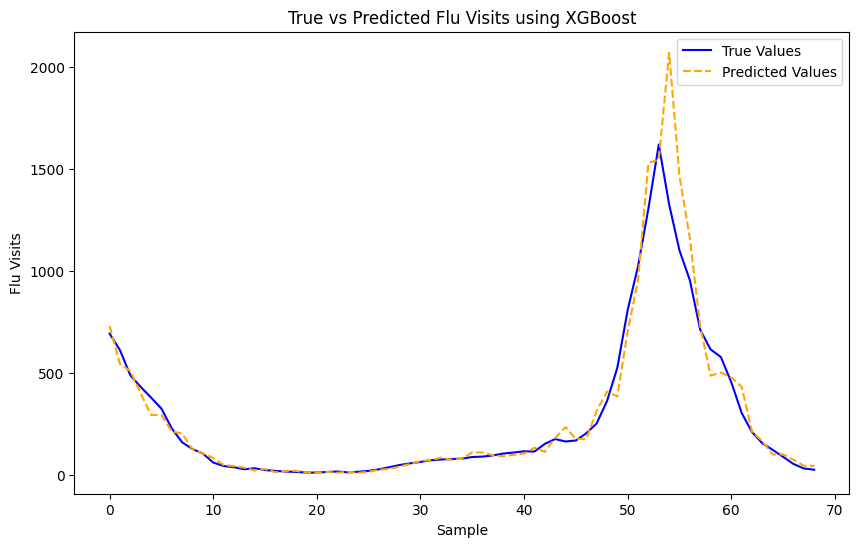

In [11]:
# visualization

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values', color='blue')
plt.plot(xgb_prediction[:, 0], label='Predicted Values', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Flu Visits')
plt.title('True vs Predicted Flu Visits using XGBoost')
plt.show()

Describe the performance of the models and compare them in a few sentences. How do they perform in comparison to each other?

## Task 3: Hyperparameter tuning via grid search

Tune the hyperparameters of the Random Forest and XGBoost models using grid search. Focus on the following hyperparameters:

Random Forest:
- n_estimators
- max_depth
- ...

XGBoost:
- gamma
- max_depth
- eta
- ...

Optimize the hyperparameters using the validation set and the refit the models using the best hyperparameters on the entire training set and evaluate them on the test set.

## Task 4: Time series cross-validation

Implement a time series cross-validation strategy to optimize the hyperparameters of the models. Except for the cross-validation strategy, the procedure is the same as in Task 3. You only need to define different training and validation sets before performing the grid search. In the end, you take the parameters that performed best across all folds and refit the models on the entire training set and evaluate them on the test set.

In [12]:
# sklearn time series split function will do the split for us?


# Optional Task:
- Take a look which other features could be good predictors for the flu visits. How does including additional features impact the overall model performance?